In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import pickle
import random
from tqdm import tqdm
import wandb
import seaborn as sns
from colorama import Fore

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.models as models

In [9]:
class PolypDataset(Dataset):
    def __init__(self, image_dir, mask_dir, csv_file, transform=None):
        self.img_paths = []
        self.labels = []
        self.images = []
        self.masks = []
        self.cropped_polyps = []
        self.transform = transform
        
               
        self.dic_label2idx = {'AD': 0, 'ASS': 1, 'HP': 2}
        self.dic_idxs2labels = {0: 'AD', 1: 'ASS', 2: 'HP'}
        
        self.df = pd.read_csv(csv_file)
        
        for i, img_id in enumerate(self.df['image_id']):
            img_path = f"{os.path.join(image_dir, str(img_id))}.tif"
            mask_path = f"{os.path.join(mask_dir, str(img_id))}.tif"
            
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            
            mask = np.array(mask)
            mask = mask > 0
            
            img = np.array(img)
            masked_image = img * np.expand_dims(mask, axis=-1)
            masked_image = Image.fromarray(masked_image)
            
            self.images.append(img)
            self.masks.append(mask)
            self.cropped_polyps.append(masked_image)
            self.labels.append(self.dic_label2idx[self.df['cls'][i]])
            
            print(f"Processed {i}/{len(self.df)} images")
        
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.cropped_polyps[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
        
    
    def visualize_image(self, image, mask, masked_image):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
            
        ax[0].imshow(image)
        ax[0].set_title("Original Image")
        ax[0].axis('off')
        
        # Masked region (polyp region only)
        ax[1].imshow(mask, cmap="gray")
        ax[1].set_title("Mask (Polyp Region)")
        ax[1].axis('off')

        # Image with mask applied
        ax[2].imshow(masked_image)
        ax[2].set_title("Masked Image (Polyp Extracted)")
        ax[2].axis('off')
        
        plt.show()

In [10]:
transform = transforms.Compose([
    transforms.Resize((224, 224), antialias=True),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     # transforms.RandomVerticalFlip(),
#     transforms.RandomRotation(degrees=30),
#     transforms.RandomResizedCrop(size=(224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


In [11]:
train_file_path = './data/train_set.pkl'

if os.path.exists(train_file_path):
    print("File already exsits. Loading...")
    with open(train_file_path, 'rb') as f:
        train_set = pickle.load(f)
    print(f"Loaded file {train_file_path}")

else:
    train_set = PolypDataset(image_dir="./data/m_train2/m_train/images",
                            mask_dir="./data/m_train2/m_train/masks",
                            csv_file="./data/m_train2/m_train/train.csv",
                            transform=transform
    )
    with open(train_file_path, "wb") as f:
        pickle.dump(train_set, f)
    
    print(f"File saved at {train_file_path}")


val_file_path = './data/val_set.pkl'
if os.path.exists(val_file_path):
    print("File already exsits. Loading...")
    with open(val_file_path, 'rb') as f:
        val_set = pickle.load(f)
    print(f"Loaded file {val_file_path}")
    
else:
    val_set = PolypDataset(image_dir="./data/m_valid/m_valid/images",
                        mask_dir="./data/m_valid/m_valid/masks",
                        csv_file="./data/m_valid/m_valid/valid.csv",
                        transform=transform
    )
    with open(val_file_path, "wb") as f:
        pickle.dump(val_set, f)
        
    print(f"File saved at {val_file_path}")

File already exsits. Loading...
Loaded file ./data/train_set.pkl
File already exsits. Loading...
Loaded file ./data/val_set.pkl


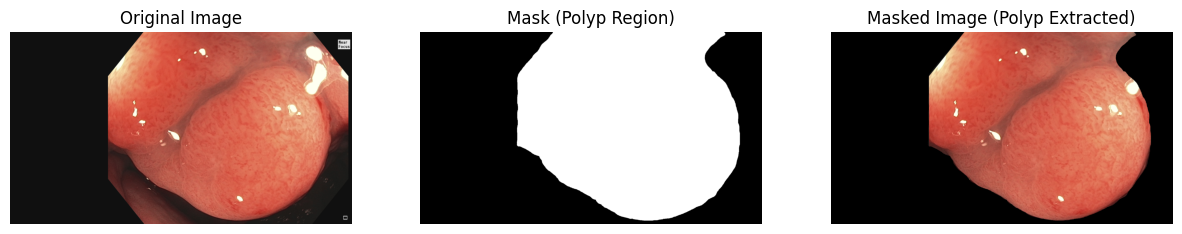

In [12]:
train_set.visualize_image(train_set.images[530], train_set.masks[530], train_set.cropped_polyps[530])

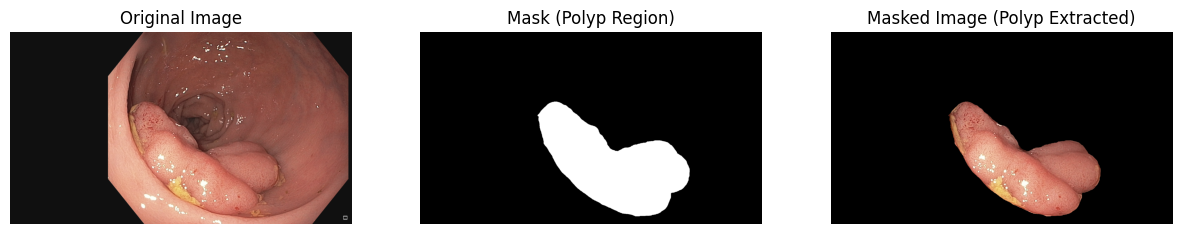

In [13]:
train_set.visualize_image(train_set.images[193], train_set.masks[193], train_set.cropped_polyps[193])

In [45]:
def get_class_weights(dataset):
    classes = np.unique(dataset.labels)  # or [0, 1, 2]

    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_set.labels)
    class_weight_dict = dict(zip(classes, class_weights))
    print(class_weight_dict)
    class_weights = torch.tensor(class_weights, dtype=torch.float)
    print(class_weights)
    
    return class_weights, class_weight_dict

class_weights_tensor, class_weights_dict = get_class_weights(train_set)

{0: 0.49096573208722744, 1: 2.1530054644808745, 2: 2.005089058524173}
tensor([0.4910, 2.1530, 2.0051])


In [46]:
batch_size = 16

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)

In [55]:
sample_weights = [class_weights_dict[label] for label in train_set.labels]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, shuffle=False, num_workers=4, drop_last=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


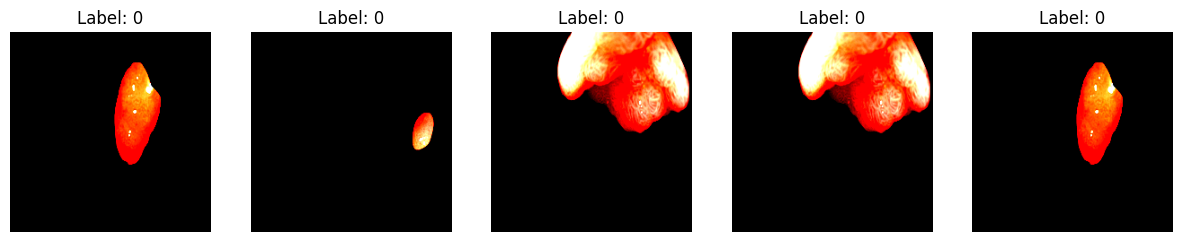

In [15]:
def inspect_batch(dataloader):
    images, labels = next(iter(dataloader))
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    
    images = images.numpy().transpose((0, 2, 3, 1))  # Change shape from (B, C, H, W) to (B, H, W, C)
    
    # Display 5 images
    for i in range(5):
        idx = random.randint(0, len(images)-1)
        ax = axes[i]
        ax.imshow(images[idx])
        ax.set_title(f"Label: {labels[idx].item()}")
        ax.axis("off")

    plt.show()
    
inspect_batch(train_loader)

In [17]:
class PolypClassificationModel(nn.Module):
    def __init__(self, num_classes):
        super(PolypClassificationModel, self).__init__()
        
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        
        in_features = self.backbone.classifier[1].in_features
        
        self.backbone.classifier = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        return self.backbone(x)

In [59]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

def train(num_epochs, model, train_loader, val_loader, optimizer, criterion, n_early_stopping, path_model=None, scheduler=None):
    best_val_loss = float('inf')
    train_loss_hist = []
    val_loss_hist = []
    early_stopping = 0

    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        train_loss = 0.0
        correct_preds = 0
        total_preds = 0

        train_loader_tqdm = tqdm(train_loader, desc=f"Training", unit="batch")

        for batch in train_loader_tqdm:
            optimizer.zero_grad()  # Clear gradients
            
            # Extract inputs and labels
            images = batch[0].to(device)  # Assuming first element is images
            labels = batch[1].to(device)  # Assuming second element is labels

            logits = model(images)
            loss = criterion(logits, labels)

            _, predicted_labels = torch.max(logits, dim=1)  
            correct_preds += (predicted_labels == labels).sum().item()
            total_preds += labels.size(0)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loader_tqdm.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        train_acc = correct_preds / total_preds
        train_loss_hist.append(avg_train_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Accuracy: {train_acc:.4f}")

        # Log training metrics to WandB
        wandb.log({"train_loss": avg_train_loss, "train_accuracy": train_acc, "epoch": epoch + 1})

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct_preds = 0
        val_total_preds = 0

        with torch.no_grad():
            val_loader_tqdm = tqdm(val_loader, desc="Validation", unit="batch")

            for batch in val_loader_tqdm:
                images = batch[0].to(device)
                labels = batch[1].to(device)

                logits = model(images)
                loss = criterion(logits, labels)

                _, predicted_labels = torch.max(logits, dim=1)
                val_correct_preds += (predicted_labels == labels).sum().item()
                val_total_preds += labels.size(0)

                val_loss += loss.item()
                val_loader_tqdm.set_postfix(loss=loss.item())

        avg_val_loss = val_loss / len(val_loader)
        val_acc = val_correct_preds / val_total_preds
        val_loss_hist.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Accuracy: {val_acc:.4f}")

        # Log validation metrics to WandB
        wandb.log({"val_loss": avg_val_loss, "val_accuracy": val_acc, "epoch": epoch + 1})

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), path_model)
            wandb.run.summary["best_val_loss"] = best_val_loss
        else:
            early_stopping += 1
            print(Fore.YELLOW + f"Early stopping: {early_stopping}")

        if early_stopping == n_early_stopping:
            print(Fore.RED + f"Stopping early at epoch {epoch+1} with best loss of {best_val_loss}.\nBest model: {path_model}")
            break

        if scheduler:
            scheduler.step()

    wandb.finish()
    print(Fore.GREEN + f"Training completed successfully!")
    return train_loss_hist, val_loss_hist


cpu


In [53]:
polyp_model = PolypClassificationModel(num_classes=len(train_set.dic_label2idx))

# Hyperparameters
learning_rate = 0.001
num_epochs = 100
early_stopping = 10
weight_decay = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(polyp_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

version = "14"

In [56]:
wandb.init(project="polyp-classification", config={
    "epochs": num_epochs,
    "batch_size": batch_size,
    "dropout": "0.5",
    "weight_decay": weight_decay,
    "loss_function": "CrossEntropyLoss",
    "optimizer": "Adam",
    "learning_rate": learning_rate,
    "model": f"model{version}",
    "scheduler": "None",
    "early_stopping": 10
})

model_description = str(polyp_model)  # Get a string representation of your model
wandb.log({"model_description": model_description})

print(Fore.CYAN + f"Training model{version}")
train_loss_hist, val_loss_hist = train(num_epochs, polyp_model, train_loader, val_loader, optimizer, criterion,
                                       n_early_stopping=10,
                                       path_model=f'./models/classification/model{version}.pth')

Training model14


Training:   0%|          | 0/49 [00:00<?, ?batch/s]

Training: 100%|██████████| 49/49 [00:40<00:00,  1.20batch/s, loss=0.556]


Epoch 1/100, Training Loss: 0.8945, Accuracy: 0.6224


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.91batch/s, loss=2.13] 


Epoch 1/100, Validation Loss: 1.0495, Accuracy: 0.4690


Training: 100%|██████████| 49/49 [00:28<00:00,  1.73batch/s, loss=0.933]


Epoch 2/100, Training Loss: 0.7006, Accuracy: 0.7245


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.61batch/s, loss=4.5]  


Epoch 2/100, Validation Loss: 1.3372, Accuracy: 0.6460
Early stopping: 1


Training: 100%|██████████| 49/49 [00:26<00:00,  1.82batch/s, loss=0.472]


Epoch 3/100, Training Loss: 0.5603, Accuracy: 0.8087


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.66batch/s, loss=1.96] 


Epoch 3/100, Validation Loss: 1.0630, Accuracy: 0.6018
Early stopping: 2


Training: 100%|██████████| 49/49 [00:29<00:00,  1.65batch/s, loss=0.481]


Epoch 4/100, Training Loss: 0.5044, Accuracy: 0.8112


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.93batch/s, loss=5.94] 


Epoch 4/100, Validation Loss: 1.5823, Accuracy: 0.6106
Early stopping: 3


Training: 100%|██████████| 49/49 [00:31<00:00,  1.54batch/s, loss=0.178]


Epoch 5/100, Training Loss: 0.4112, Accuracy: 0.8457


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.50batch/s, loss=11.8] 


Epoch 5/100, Validation Loss: 3.0861, Accuracy: 0.4602
Early stopping: 4


Training: 100%|██████████| 49/49 [00:32<00:00,  1.51batch/s, loss=0.402] 


Epoch 6/100, Training Loss: 0.3849, Accuracy: 0.8622


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.68batch/s, loss=7.53] 


Epoch 6/100, Validation Loss: 1.7623, Accuracy: 0.5929
Early stopping: 5


Training: 100%|██████████| 49/49 [00:36<00:00,  1.35batch/s, loss=0.288] 


Epoch 7/100, Training Loss: 0.3514, Accuracy: 0.8788


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.81batch/s, loss=5.37] 


Epoch 7/100, Validation Loss: 1.6259, Accuracy: 0.5664
Early stopping: 6


Training: 100%|██████████| 49/49 [00:28<00:00,  1.71batch/s, loss=0.0554]


Epoch 8/100, Training Loss: 0.3246, Accuracy: 0.8916


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.62batch/s, loss=3]    


Epoch 8/100, Validation Loss: 1.2387, Accuracy: 0.6460
Early stopping: 7


Training: 100%|██████████| 49/49 [00:35<00:00,  1.37batch/s, loss=0.516] 


Epoch 9/100, Training Loss: 0.2263, Accuracy: 0.9273


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.63batch/s, loss=5.36] 


Epoch 9/100, Validation Loss: 1.7042, Accuracy: 0.6637
Early stopping: 8


Training: 100%|██████████| 49/49 [00:29<00:00,  1.66batch/s, loss=0.134]


Epoch 10/100, Training Loss: 0.2950, Accuracy: 0.9005


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.52batch/s, loss=8.77] 


Epoch 10/100, Validation Loss: 2.0425, Accuracy: 0.6372
Early stopping: 9


Training: 100%|██████████| 49/49 [00:38<00:00,  1.28batch/s, loss=0.11]  


Epoch 11/100, Training Loss: 0.2841, Accuracy: 0.9094


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.56batch/s, loss=4.23] 

Epoch 11/100, Validation Loss: 1.4326, Accuracy: 0.6814
Early stopping: 10
Stopping early at epoch 11 with best loss of 1.0495090261101723.
Best model: ./models/classification/model14.pth


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇██
train_accuracy,▁▃▅▅▆▇▇▇█▇█
train_loss,█▆▄▄▃▃▂▂▁▂▂
val_accuracy,▁▇▅▆▁▅▄▇▇▇█
val_loss,▁▂▁▃█▃▃▂▃▄▂
best_val_loss,1.04951
epoch,11
model_description,PolypClassificationM...
train_accuracy,0.90944
train_loss,0.28413
val_accuracy,0.68142


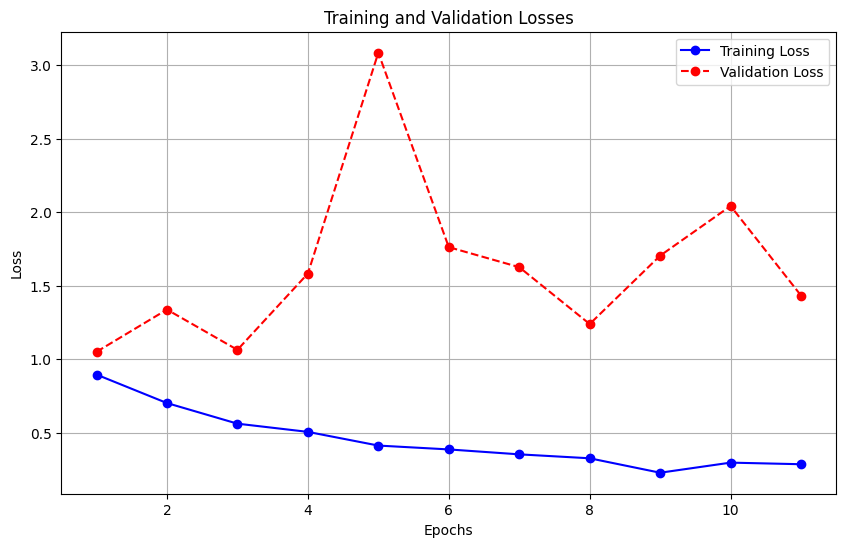

In [57]:
def plot_loss(train_loss_hist, val_loss_hist):
    plt.figure(figsize=(10, 6))
    
    # Plotting training loss
    plt.plot(range(1, len(train_loss_hist) + 1), train_loss_hist, label="Training Loss", color="blue", linestyle='-', marker='o')
    
    # Plotting validation loss
    plt.plot(range(1, len(val_loss_hist) + 1), val_loss_hist, label="Validation Loss", color="red", linestyle='--', marker='o')
    
    plt.title("Training and Validation Losses")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig(f'./results/loss{version}.png')
    plt.show()

plot_loss(train_loss_hist, val_loss_hist)


/tmp/ipykernel_734440/2448391766.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'./models/classification/model{version}.pth'))


Loaded model14


Evaluating: 100%|██████████| 8/8 [00:02<00:00,  2.96batch/s]


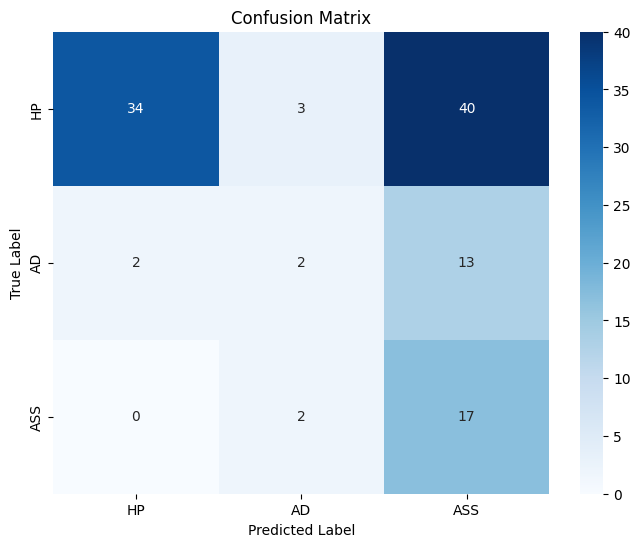

Saved confusion matrix at ./results/confusion_matrix14.png
Accuracy: 0.4690
Precision: 0.7274
Recall: 0.4690
F1 Score: 0.4994
Saved report metrics at ./results/metrics_report14.csv


In [58]:
def evaluate_model(model, val_loader):
    model.load_state_dict(torch.load(f'./models/classification/model{version}.pth'))
    print(Fore.GREEN + f"Loaded model{version}")
    model.eval()
    predicted_labels_idxs = []
    true_labels_idxs = []
    
    with torch.no_grad():
        val_loader_tqdm = tqdm(val_loader, desc="Evaluating", unit="batch")
        
        for batch in val_loader_tqdm:
            images = batch[0].to(device)
            labels_idxs = batch[1].to(device)
            
            logits = model(images)
            _, pred_labels_idxs = torch.max(logits, dim=1)
            
            predicted_labels_idxs.extend(pred_labels_idxs.cpu().numpy())
            true_labels_idxs.extend(labels_idxs.cpu().numpy())

    predicted_labels = [train_set.dic_idxs2labels[idx] for idx in predicted_labels_idxs]
    true_labels = [train_set.dic_idxs2labels[idx] for idx in true_labels_idxs]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='weighted', zero_division=0)
    
    all_metrics = classification_report(true_labels, predicted_labels, output_dict=True)
    df_metrics = pd.DataFrame(all_metrics).transpose()
    df_metrics.to_csv(f'./results/metrics_report{version}.csv')
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(set(true_labels)), yticklabels=list(set(true_labels)))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'./results/confusion_matrix{version}.png')
    plt.show()
    print(f"Saved confusion matrix at ./results/confusion_matrix{version}.png")

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
    
    print(f"Saved report metrics at ./results/metrics_report{version}.csv")
    
    return metrics, conf_matrix

metrics, conf_matrix = evaluate_model(polyp_model, val_loader)